In [1]:
from typing import Union

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colorbar as mbar
import seaborn as sns

from scipy.ndimage import gaussian_filter as smooth

from scipy.stats import mannwhitneyu as mnu
from scipy.stats import wilcoxon

from sklearn.metrics.pairwise import cosine_similarity as cosine
from scipy.stats import pearsonr as pearson
from scipy.stats import spearmanr as spearman
from scipy.stats import kendalltau as kendall
from sklearn.linear_model import Ridge

from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

## Definitions ##

In [2]:
def movavg(input, win=[], step=[]):
    '''
    Args:
        input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        win:   size of the window for moving averge
        step:  step size for moving forward
    Returns:
        output:     matrix of output data, with shape (Neurons,Stimuli,Timepoints),
                    where Timepoints are following the moving average process
        timestamps: (N,) vector of timepoints, corresponding to the output data, 
                    where N is the number of timepoints following the moving average process
    '''

    if not win: win = input.shape[2] // 25
    if not step: step = win // 10
    
    bins = [np.arange(0,input.shape[2]-win+1,step), 
            np.arange(win, input.shape[2]+1, step)]
    
    nbins = np.array(bins).shape[1]
    output = np.nan * np.zeros((input.shape[0], input.shape[1], nbins))

    timestamps = []
    counter_bin = 0
    for bin_st, bin_end in tqdm(zip(bins[0],bins[1])):
        timestamps.append(np.nanmean([bin_st, bin_end]))
        output[:,:,counter_bin] = np.nanmean(input[:,:,bin_st:bin_end], axis=2)
        counter_bin += 1

    return output, np.array(timestamps)


def mk_repmat_kernel(input_ls, plot_kernel=False):
    '''
    Args:
        input_ls:    list with the number of samples per condition, i.e., 
                     the list size is the number of categories
        plot_kernel: if True, the created kernel will be plotted
    Returns:
        kernel: (N,N) theoretical ground-truth representatational matrix,
                where N is the total number of samples
    '''

    kernel = np.zeros([sum(input_ls),sum(input_ls)])
    counter_ind = 0
    for i in tqdm(input_ls):
        inds = np.arange(counter_ind, counter_ind+i)
        counter_ind += i
        kernel[np.ix_(inds,inds)] = 1
        
    if plot_kernel:
        plt.figure(figsize=(2,2))
        plt.imshow(kernel, cmap='coolwarm')
        plt.axis('off')

    return kernel


def mk_repmat_data(input_data, sim_method='cosine', print_info=False):
    '''
    Args:
        input_data: matrix of input data, with shape (Neurons,Stimuli)
        sim_method: method for creating representatational matrix
                    cosine, for cosine similarity
                    spearman, for spearman correlation 
        print_info: if True, the progression will be printed
    Returns:
        repmat: (N,N) representatational matrix, where N is the total number of samples
    '''

    if sim_method=='cosine':
        repmat = cosine(input_data.T)
    elif sim_method=='spearman':
        CorRows = []
        for stim_i in range(input_data.shape[1]):
            CorCols = []
            for stim_j in range(input_data.shape[1]):
                CorCols.append(spearman(input_data[:,stim_i], input_data[:,stim_j])[0])

                if print_info:
                    print('stim_i: ' + str(((stim_i+1)/input_data.shape[1])*100) +
                          ' | ' + 'stim_j: ' + str(((stim_j+1)/input_data.shape[1])*100))

            CorRows.append(CorCols)
        repmat = np.array(CorRows)
    
    return repmat

def mk_total_repmat_data(input_data, sim_method='cosine'):
    '''
    Args:
        input_data: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        sim_method: method for creating representatational matrix
                    cosine, for cosine similarity
                    spearman, for spearman correlation 
    Returns:
        total_repmat: (N,N,T) representatational matrix, where N is the total number of samples and
                      T is the number of time-points
    '''

    total_repmat = []
    for iTime in range(input_data.shape[2]):
        tmp_retmat = mk_repmat_data(input_data=input_data[:,:,iTime], sim_method=sim_method, print_info=False)
        total_repmat.append(tmp_retmat)
    return np.transpose(np.array(total_repmat), (1,2,0))


def plot_repmat(input_repmat, plot_sz=3, show_clb=False, titles=[], colormap='coolwarm', cbar_label='Cosine Similarity (au)', fig_title=''):
    '''
    Args:
        input_repmat: (M,N,N) representatational matrices, where M is the number of conditions and
                      N is the total number of samples
        plot_sz:      size of the generated plot
        show_clb:     if True, colorbar will be shown
        titles:       list of titles of each representatational matrix
        colormap:     colormap for the generated plot
        cbar_label:   colorbar label
    Returns:
        none
    '''

    if not titles: titles=['']*len(input_repmat)
    if show_clb==True:
        fig, axs = plt.subplots(nrows=1, ncols=len(input_repmat)+1, figsize=(3*plot_sz,plot_sz),  dpi=500)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=len(input_repmat), figsize=(3*plot_sz,plot_sz),  dpi=500)

    for ax,repmat,tle in zip(axs.flatten(), input_repmat, titles):
        ax.imshow(repmat, cmap=colormap)
        ax.set_title(tle, fontsize=5)
        ax.axis('off')
    if show_clb:
        clb = mbar.ColorbarBase(ax=axs[-1], cmap=colormap, orientation="vertical", ticks=[0,1])
        clb.set_label(cbar_label, fontsize=plot_sz*3)
        clb.outline.set_visible(False)
    plt.suptitle(fig_title, fontsize=plot_sz*10)


def m_plot(input_data, smooth_win, colors, labels, plot_title, timepoints=[], figure_size=(8,3)):
    '''
    Args:
        input_data:  (N,M,T) matrix of input data, (Conditions,Samples,Timepoints)
        smooth_win:  smoothing window
        colors:      (N,4) matrix of colors for the generated plots in [R,G,B,FaceAlpha] format,
                     where N is the number of conditions. FaceAlpha in the scale=[0-255]
        labels:      (N,) list of labels for the generated plots, where N is the number of conditions
        plot_title:  title of the generated plot
        timepoints:  (N,) vaetor of timepoints
        figure_size: two-item tuple containing width and height of the figure
    Returns:
        none
    '''

    colors = np.array(colors) / np.array(255)
    timepoints = np.array(timepoints)
    if timepoints.size==0: timepoints = np.arange(0,input_data.shape[2])
    
    plt.figure(figsize=figure_size)
    # sns.set_style('darkgrid')
    for iCond in range(input_data.shape[0]):
        data_ave = smooth(np.nanmean(input_data[iCond], axis=0), smooth_win)
        data_std = smooth(np.nanstd(input_data[iCond], axis=0), smooth_win)

        data_std_up  = data_ave + data_std
        data_std_low = data_ave - data_std

        plt.fill_between(timepoints, data_std_up, data_std_low, color=colors[iCond], label='_nolegend_')
        plt.plot(timepoints, data_ave, color=colors[iCond,:3], lw=3, label=labels[iCond])
    
    ylim = plt.ylim()
    plt.fill_between([0, 80], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=.2, edgecolor=None)
    plt.legend(frameon=False, fontsize=10)
    plt.title(plot_title)


def compute_similarity(data_mat, kernel_mat, sim_method='kendall'):
    '''
    Args:
        data_mat:   (N,N) representatational matrix created from data,
                    where N is the number of conditions
        kernel_mat: (N,N) theoretical ground-truth representatational matrix,
                    where N is the number of conditions
        sim_method: method to calculate similarity
    Returns:
        similarity: similarity value between data_mat and kernel_mat
    '''
    if sim_method!='kendall':
        data_mat = data_mat.reshape((data_mat.shape[0]**2,1))
        kernel_mat = kernel_mat.reshape((kernel_mat.shape[0]**2,1))

    if sim_method=='kendall':
        similarity = kendall(data_mat, kernel_mat)[0]
    elif sim_method=='spearman':
        similarity = spearman(data_mat, kernel_mat)[0]
    elif sim_method=='pearson':
        similarity = pearson(data_mat, kernel_mat)[0]

    return similarity


def compute_rsa(data_input, conds_ls=[], sp_kernel=[], sim_method='kendall', print_info=False):
    '''
    Args:
        data_input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        conds_ls:   list with the number of samples per condition, i.e., the list size is the number
                    of categories, and each item is the number of stimuli per that category
        sp_kernel:  (N,N) representatational matrix, i.e., specific kernel,
                    where N is the number of stimuli
        sim_method: method to calculate similarity
        print_info: if True, the progression will be printed
    Returns:
        rsa: (N,) vector of similarity values, where N is the number of timepoints
    '''
    
    if not sp_kernel: kernel = mk_repmat_kernel(conds_ls)
    elif not conds_ls: kernel = sp_kernel

    rsa = []
    for i_time in range(data_input.shape[2]):
        temp_mat = []
        temp_mat = mk_repmat_data(data_input[:,:,i_time])
        rsa.append(compute_similarity(temp_mat, kernel, sim_method))

        if print_info:
            print('% ' + str(((i_time+1)/data_input.shape[2])*100))
            
    return np.array(rsa)


def repmat_extremizer(input_repmat, szs_ls, coeffs=[1,1], clip_vals=[0,1]):
    '''
    Args:
        input_repmat: (N,N) representatational matrix, where N is the total number of stimuli
        szs_ls:       (N,) list with the number of samples per condition, i.e., 
                      the list size is the number of categories
        coeffs:       (2,) list of coefficients to scale the "input_repmat"; members of the same category
                      will be scaled by coeffs[0], and members of different categories will be scaled by
                      coeffs[1]
        clip_vals:    (2,) list of minimum (clip_vals[0]) and maximum (clip_vals[1]) acceptable values for
                      representatational matrix
    Returns:
        trans_repmat: (N,N) transformed representatational matrix, where N is the total number of stimuli
    '''

    coeffs = np.sort(coeffs)
    clip_vals = np.sort(clip_vals)
    coeff_mat = np.array(coeffs[0]) * np.ones([input_repmat.shape[0],input_repmat.shape[1]])
    counter_ind = 0
    for i in tqdm(szs_ls):
        inds = np.arange(counter_ind, counter_ind+i)
        counter_ind += i
        coeff_mat[np.ix_(inds,inds)] = coeffs[1]
    trans_repmat = input_repmat * coeff_mat
    trans_repmat[trans_repmat<clip_vals[0]] = clip_vals[0]
    trans_repmat[trans_repmat>clip_vals[1]] = clip_vals[1]

    return trans_repmat


def rand_idx_gen(cyles, cat_inds, stim_num, replacement=False):
    '''
    Args:
        cyles:       number repetitions or cycles
        cat_inds:    (N,) list of indices in each category/condition, where N is the number of categories/conditions,
                     and each item in the list is a np.array of indices for that category/condition.
        stim_num:    number of samples for each category/condition
        replacement: if True, sampling will be with replacement
    Returns:
        idx_rand: (N,M) np.array of the generated random indices, (cyles,cat_inds*stim_num)
    '''
    np.random.seed(15)
    idx_rand = []

    for iCycle in range(cyles):
        tmp_rand_tdx = []
        for i,iCat in enumerate(cat_inds):
            tmp_rand_tdx = np.concatenate((tmp_rand_tdx, iCat[np.random.choice(iCat.shape[0], stim_num, replace=replacement)]), axis=0)
        idx_rand.append(tmp_rand_tdx)

    return np.array(idx_rand).astype('int')


def rsaGranger(src: np.array, dst: np.array, n: int, k: int, mdl=Ridge, print_info=False, timepoints=[]) -> Union[np.array, dict]:
    '''
    Args:
        src:        (N,N,T) array of representatational matrices over time for the sender area, where T is time and 
                    each (N,N) is a representatational matrix at a time-point, in which N is the total number of stimuli
        dst:        same as "src", for the reciever area. "src" and "dst" must have the same shape
        n:          ---
        k:          ---
        mdl:        ---
        print_info: if True, the progression will be printed
        timepoints: (N,) np.array vector of timepoints
    Returns:
        granger_vals: value of granger predictivity for "src-to-dst" direction
        time_stamps:  (N,) vector of new timepoints
    '''

    assert((src.shape == dst.shape))
    timepoints = np.array(timepoints)
    if timepoints.size==0: timepoints = np.arange(0,src.shape[2])

    triu = np.triu_indices(src.shape[0], k=1)
    time_stamps, unex_r, unex_f, norm_w = [], [], [], []

    for iTime in range(n+k, src.shape[2]):
        
        y = dst[triu[0], triu[1], iTime]
        x_r = dst[triu[0], triu[1], (iTime-n-k):(iTime-k+1)]
        x_f = np.concatenate((
            dst[triu[0], triu[1], (iTime-n-k):(iTime-k+1)], 
            src[triu[0], triu[1], (iTime-n-k):(iTime-k+1)]), axis=-1)
        
        p_r = mdl.fit(x_r, y).predict(x_r)
        p_f = mdl.fit(x_f, y).predict(x_f)

        unex_r.append( (y - p_r) @ (y - p_r).T )
        unex_f.append( (y - p_f) @ (y - p_f).T )
        norm_w.append(np.linalg.norm(mdl.coef_))

        t1 = np.nanmean(timepoints[(iTime-n-k):(iTime-k+1)])
        t2 = np.nanmean(timepoints[(iTime-k+1):iTime])
        time_stamps.append(np.nanmean([t1,t2]))
        # time_stamps.append(iTime)

        if print_info:
            print('% ' + str(((iTime+1)/src.shape[2])*100)) 

    unex_r = np.array(unex_r)
    unex_f = np.array(unex_f)

    return np.log(unex_r/unex_f), np.array(time_stamps) #, {'reduced': unex_r, 'full': unex_f, 'norm_w': norm_w}



In [3]:
# load data
FigDir = '../Results/'

FileDir_IT = '../Data/Resp_IT.mat'
temp_file_IT = loadmat(FileDir_IT)

FileDir_PFC = '../Data/Resp_PFC.mat'
temp_file_PFC = loadmat(FileDir_PFC)

# model
alpha = 25

# parameters
SmoothWin = 20
step = 1
time_base = 80

abs_level = 2
if abs_level == 1:
    myCond = 'Animacy'
    stim_num = 50
    indc1 = np.arange(0,175,1)
    indc2 = np.arange(175,335,1)
elif abs_level == 2:
    myCond = 'FaceBody'
    stim_num = 20
    indc1 = np.arange(0,35,1)
    indc2 = np.arange(35,75,1)
ind_all = np.concatenate((indc1, indc2), axis=0)

# sub-sampling
cycel_num = 200
cat_inds = [indc1,indc2]
idx_rand = rand_idx_gen(cycel_num, cat_inds, stim_num, replacement=False)

resp_it, time_stamps  = movavg(temp_file_IT['resp_it'], SmoothWin, step)
resp_pfc, time_stamps  = movavg(temp_file_PFC['resp_pfc'], SmoothWin, step)

time_stamps -= time_base

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## RSA Granger ##

In [4]:
mdl = Ridge(fit_intercept=True, positive=False, alpha=alpha)
n, k = 50, 25

it2pfc, pfc2it = [], []
for iCycle in range(cycel_num):
    it2pfc.append(rsaGranger(mk_total_repmat_data(resp_it[:,idx_rand[iCycle],:]), mk_total_repmat_data(resp_pfc[:,idx_rand[iCycle],:]),
                             n=n, k=k, mdl=mdl, timepoints=time_stamps)[0])
    pfc2it.append(rsaGranger(mk_total_repmat_data(resp_pfc[:,idx_rand[iCycle],:]), mk_total_repmat_data(resp_it[:,idx_rand[iCycle],:]),
                             n=n, k=k, mdl=mdl, timepoints=time_stamps)[0])

timestamps = rsaGranger(mk_total_repmat_data(resp_it[:,idx_rand[0],:]), mk_total_repmat_data(resp_pfc[:,idx_rand[0],:]),
                        n=n, k=k, mdl=mdl, timepoints=time_stamps)[1]

it2pfc = np.array(it2pfc)
pfc2it = np.array(pfc2it)
# timestamps[:50]

WilcoxonResult(statistic=1392.5, pvalue=1.7544975696683878e-24)

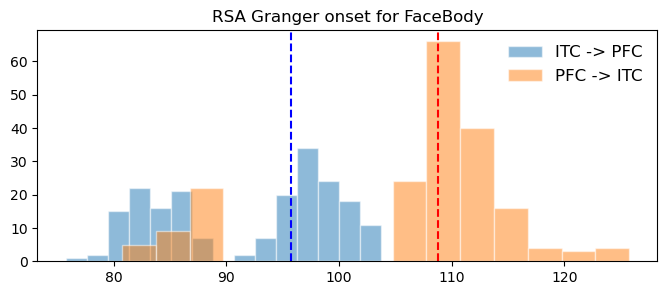

In [5]:
base_time_idx = 50
figure_size = (8,3)
times = timestamps
std_thr = 50

onsets_it2pfc = []
for i,iRep in enumerate(smooth(it2pfc,3)):
    tmp_base_std = np.nanstd(iRep[:base_time_idx])
    bools = iRep > std_thr*tmp_base_std
    if bools.sum()>0: onsets_it2pfc.append(times[bools][0])
    else: onsets_it2pfc.append(np.nan)

onsets_pfc2it = []
for i,iRep in enumerate(smooth(pfc2it,3)):
    tmp_base_std = np.nanstd(iRep[:base_time_idx])
    bools = iRep > std_thr*tmp_base_std
    if bools.sum()>0: onsets_pfc2it.append(times[bools][0])
    else: onsets_pfc2it.append(np.nan)


plt.figure(figsize=figure_size)
plt.hist(onsets_it2pfc, bins=15, alpha=.5, label='ITC -> PFC', edgecolor=[1,1,1])
plt.hist(onsets_pfc2it, bins=15, alpha=.5, label='PFC -> ITC', edgecolor=[1,1,1])
plt.title('RSA Granger onset for '+myCond)
plt.legend(frameon=False, fontsize=12)
# plt.xlim([70,140])
plt.axvline(np.nanmedian(onsets_it2pfc), ls='--', color='b')
plt.axvline(np.nanmedian(onsets_pfc2it), ls='--', color='r')


idx_non_nan = np.array([(~np.isnan(onsets_pfc2it)) & (~np.isnan(onsets_it2pfc))])[0]
wilcoxon(np.array(onsets_pfc2it)[idx_non_nan], np.array(onsets_it2pfc)[idx_non_nan], method='exact')

WilcoxonResult(statistic=1392.5, pvalue=1.7544975696683878e-24)

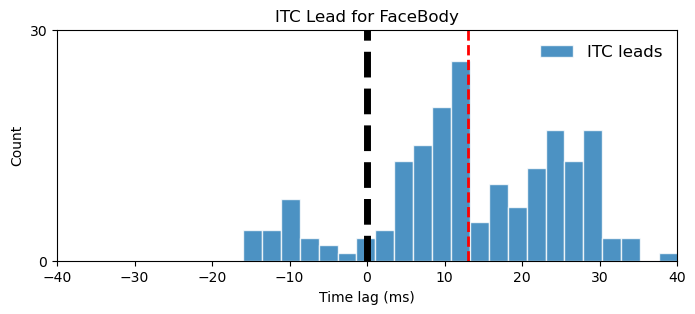

In [8]:
plot_xlim = [-40,40]
plot_ylim = [0,30]
figure_size = (8,3)

diffs = np.array(onsets_pfc2it)[idx_non_nan] - np.array(onsets_it2pfc)[idx_non_nan]

plt.figure(figsize=figure_size)
plt.hist(diffs, bins=25, alpha=.8, label='ITC leads', edgecolor=[1,1,1])

plt.axvline(0, ls='--', color='k', lw=5)
plt.axvline(np.nanmedian(diffs), ls='--', color='r', lw=2)

plt.xlabel('Time lag (ms)')
plt.ylabel('Count')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.yticks([plot_ylim[0],plot_ylim[1]])
plt.xticks(np.arange(plot_xlim[0],plot_xlim[1]+1,10))

plt.title('ITC Lead for '+myCond)
plt.legend(frameon=False, fontsize=12)

wilcoxon(diffs)

# plt.savefig(FigDir+'rsagranger_fb_stat_both.svg')

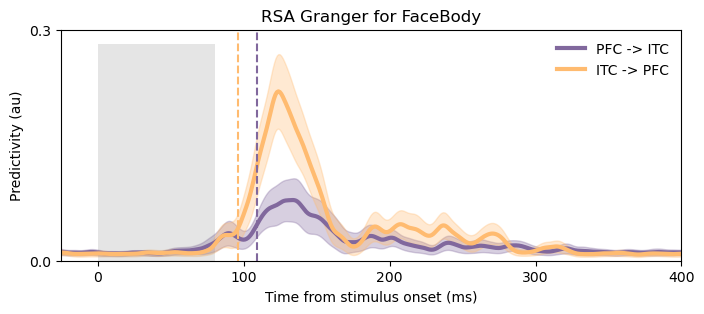

In [11]:
plot_xlim = [-25,400]
figure_size=(8,3)

m_plot(np.array([pfc2it,it2pfc]), 3, [[129, 104, 157, 80],[255, 187, 112, 80]], ['PFC -> ITC','ITC -> PFC'],
       'RSA Granger for '+myCond, timepoints=timestamps, figure_size=figure_size)

plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylim([0,.3])
plt.yticks([0,.3])

plt.xlabel('Time from stimulus onset (ms)')
plt.ylabel('Predictivity (au)')

plt.axvline(np.nanmedian(onsets_it2pfc), ls='--', color=[255/255, 187/255, 112/255, 1])
plt.axvline(np.nanmedian(onsets_pfc2it), ls='--', color=[129/255, 104/255, 157/255, 1])

# plt.savefig(FigDir+'rsagranger_fb_both.svg')

WilcoxonResult(statistic=1475.0, pvalue=7.649092524877405e-25)

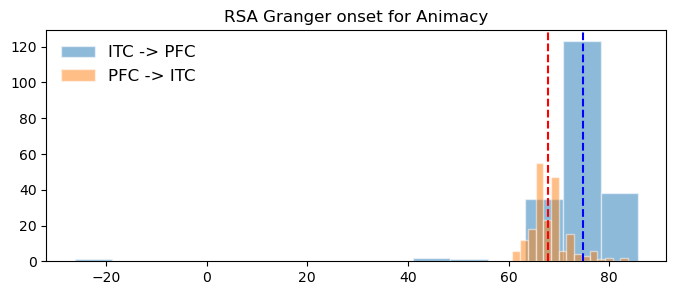

In [15]:
base_time_idx = 50
figure_size = (8,3)
times = timestamps
std_thr = 50

onsets_it2pfc = []
for i,iRep in enumerate(smooth(it2pfc,3)):
    tmp_base_std = np.nanstd(iRep[:base_time_idx])
    bools = iRep > std_thr*tmp_base_std
    if bools.sum()>0: onsets_it2pfc.append(times[bools][0])
    else: onsets_it2pfc.append(np.nan)

onsets_pfc2it = []
for i,iRep in enumerate(smooth(pfc2it,3)):
    tmp_base_std = np.nanstd(iRep[:base_time_idx])
    bools = iRep > std_thr*tmp_base_std
    if bools.sum()>0: onsets_pfc2it.append(times[bools][0])
    else: onsets_pfc2it.append(np.nan)


plt.figure(figsize=figure_size)
plt.hist(onsets_it2pfc, bins=15, alpha=.5, label='ITC -> PFC', edgecolor=[1,1,1])
plt.hist(onsets_pfc2it, bins=15, alpha=.5, label='PFC -> ITC', edgecolor=[1,1,1])
plt.title('RSA Granger onset for '+myCond)
plt.legend(frameon=False, fontsize=12)
# plt.xlim([70,140])
plt.axvline(np.nanmedian(onsets_it2pfc), ls='--', color='b')
plt.axvline(np.nanmedian(onsets_pfc2it), ls='--', color='r')


idx_non_nan = np.array([(~np.isnan(onsets_pfc2it)) & (~np.isnan(onsets_it2pfc))])[0]
wilcoxon(np.array(onsets_pfc2it)[idx_non_nan], np.array(onsets_it2pfc)[idx_non_nan], method='exact')

WilcoxonResult(statistic=1475.0, pvalue=7.649092524877405e-25)

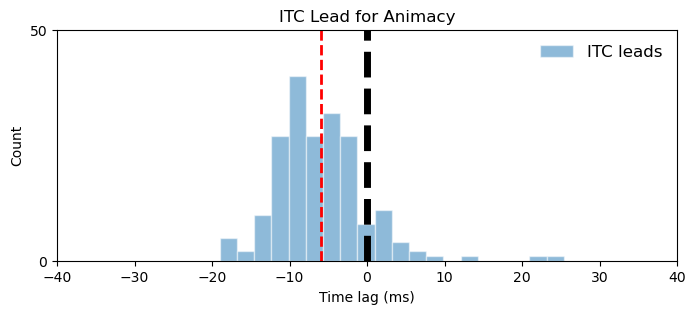

In [37]:
plot_xlim = [-40,40]
plot_ylim = [0,50]
figure_size = (8,3)

diffs = np.array(onsets_pfc2it)[idx_non_nan] - np.array(onsets_it2pfc)[idx_non_nan]

plt.figure(figsize=figure_size)
plt.hist(diffs, bins=50, alpha=.5, label='ITC leads', edgecolor=[1,1,1])

plt.axvline(0, ls='--', color='k', lw=5)
plt.axvline(np.nanmedian(diffs), ls='--', color='r', lw=2)

plt.xlabel('Time difference (ms)')
plt.ylabel('Count')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.yticks([plot_ylim[0],plot_ylim[1]])
plt.xticks(np.arange(plot_xlim[0],plot_xlim[1]+1,10))

plt.title('ITC Lead for '+myCond)
plt.legend(frameon=False, fontsize=12)

wilcoxon(diffs)

# plt.savefig(FigDir+'rsagranger_animacy_stat_both.svg')

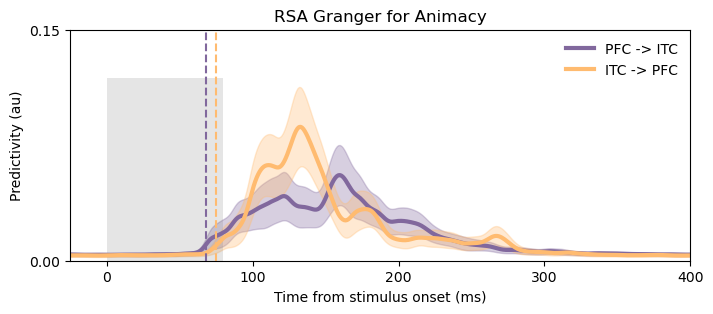

In [31]:
plot_xlim = [-25,400]
figure_size=(8,3)

m_plot(np.array([pfc2it,it2pfc]), 3, [[129, 104, 157, 80],[255, 187, 112, 80]], ['PFC -> ITC','ITC -> PFC'],
       'RSA Granger for '+myCond, timepoints=timestamps, figure_size=figure_size)

plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylim([0,.15])
plt.yticks([0,.15])

plt.xlabel('Time from stimulus onset (ms)')
plt.ylabel('Predictivity (au)')

plt.axvline(np.nanmedian(onsets_pfc2it), ls='--', color=[129/255, 104/255, 157/255, 1])
plt.axvline(np.nanmedian(onsets_it2pfc), ls='--', color=[255/255, 187/255, 112/255, 1])

# plt.savefig(FigDir+'rsagranger_animacy_both.svg')

## RSA ##

In [238]:
itc, pfc = [], []
for iCycle in range(cycel_num):
   itc.append(compute_rsa(resp_it[:,idx_rand[iCycle],:], conds_ls=[stim_num,stim_num]))
   pfc.append(compute_rsa(resp_pfc[:,idx_rand[iCycle],:], conds_ls=[stim_num,stim_num]))
   print((iCycle/cycel_num)*100)

itc = np.array(itc)
pfc = np.array(pfc)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

1.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

1.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

2.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

2.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

3.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

3.5000000000000004


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

4.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

4.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

5.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

5.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

6.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

6.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

7.000000000000001


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

7.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

8.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

8.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

9.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

9.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

10.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

10.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

11.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

11.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

12.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

12.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

13.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

13.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

14.000000000000002


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

14.499999999999998


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

15.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

15.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

16.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

16.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

17.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

17.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

18.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

18.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

19.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

19.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

20.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

20.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

21.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

21.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

22.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

22.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

23.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

23.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

24.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

24.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

25.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

25.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

26.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

26.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

27.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

27.500000000000004


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

28.000000000000004


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

28.499999999999996


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

28.999999999999996


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

29.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

30.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

30.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

31.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

31.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

32.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

32.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

33.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

33.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

34.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

34.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

35.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

35.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

36.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

36.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

37.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

37.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

38.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

38.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

39.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

39.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

40.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

40.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

41.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

41.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

42.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

42.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

43.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

43.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

44.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

44.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

45.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

45.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

46.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

46.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

47.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

47.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

48.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

48.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

49.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

49.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

50.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

50.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

51.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

51.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

52.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

52.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

53.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

53.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

54.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

54.50000000000001


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

55.00000000000001


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

55.50000000000001


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

56.00000000000001


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

56.49999999999999


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

56.99999999999999


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

57.49999999999999


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

57.99999999999999


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

58.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

59.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

59.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

60.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

60.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

61.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

61.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

62.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

62.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

63.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

63.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

64.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

64.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

65.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

65.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

66.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

66.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

67.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

67.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

68.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

68.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

69.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

69.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

70.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

70.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

71.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

71.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

72.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

72.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

73.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

73.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

74.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

74.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

75.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

75.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

76.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

76.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

77.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

77.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

78.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

78.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

79.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

79.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

80.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

80.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

81.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

81.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

82.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

82.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

83.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

83.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

84.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

84.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

85.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

85.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

86.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

86.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

87.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

87.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

88.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

88.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

89.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

89.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

90.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

90.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

91.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

91.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

92.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

92.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

93.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

93.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

94.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

94.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

95.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

95.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

96.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

96.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

97.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

97.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

98.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

98.5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

99.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

99.5


WilcoxonResult(statistic=6762.0, pvalue=0.0002734358002714901)

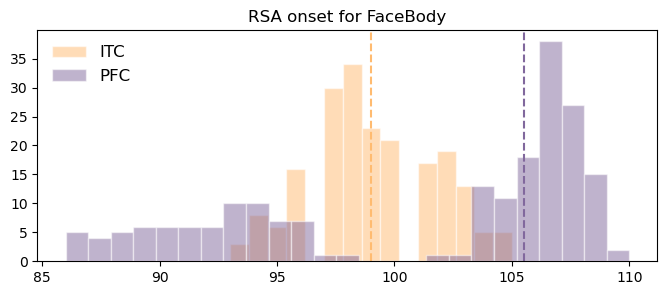

In [239]:
figure_size = (8,3)
times = time_stamps
base_time_idx = (times>-50) & (times<50)
std_thr = 10

onsets_itc = []
for i,iRep in enumerate(smooth(itc,3)):
    tmp_base_std = np.nanstd(iRep[base_time_idx])
    
    bools = iRep > std_thr*tmp_base_std
    if bools.sum()>0: onsets_itc.append(times[bools][0])
    else: onsets_itc.append(np.nan)

onsets_pfc = []
for i,iRep in enumerate(smooth(pfc,3)):
    tmp_base_std = np.nanstd(iRep[base_time_idx])
    
    bools = iRep > std_thr*tmp_base_std
    if bools.sum()>0: onsets_pfc.append(times[bools][0])
    else: onsets_pfc.append(np.nan)


plt.figure(figsize=figure_size)
plt.hist(onsets_itc, bins=15, alpha=.5, label='ITC', facecolor=[255/255, 187/255, 112/255, 1], edgecolor=[1,1,1])
plt.hist(onsets_pfc, bins=25, alpha=.5, label='PFC', facecolor=[129/255, 104/255, 157/255, 1], edgecolor=[1,1,1])
plt.title('RSA onset for '+myCond)
plt.legend(frameon=False, fontsize=12)
# plt.xlim([70,140])
plt.axvline(np.nanmedian(onsets_itc), ls='--', color=[255/255, 187/255, 112/255, 1])
plt.axvline(np.nanmedian(onsets_pfc), ls='--', color=[129/255, 104/255, 157/255, 1])

idx_non_nan = np.array([(~np.isnan(onsets_pfc)) & (~np.isnan(onsets_itc))])[0]
wilcoxon(np.array(onsets_pfc)[idx_non_nan], np.array(onsets_itc)[idx_non_nan], method='exact')

In [240]:
times = time_stamps

peak_itc = []
for i,iRep in enumerate(smooth(itc,3)):
    peak_itc.append(times[np.argmax(iRep)])

peak_pfc = []
for i,iRep in enumerate(smooth(pfc,3)):
    peak_pfc.append(times[np.argmax(iRep)])

peak_itc = np.array(peak_itc)
peak_pfc = np.array(peak_pfc)

wilcoxon(peak_itc, peak_pfc, method='exact')

WilcoxonResult(statistic=595.0, pvalue=8.793568388226001e-43)

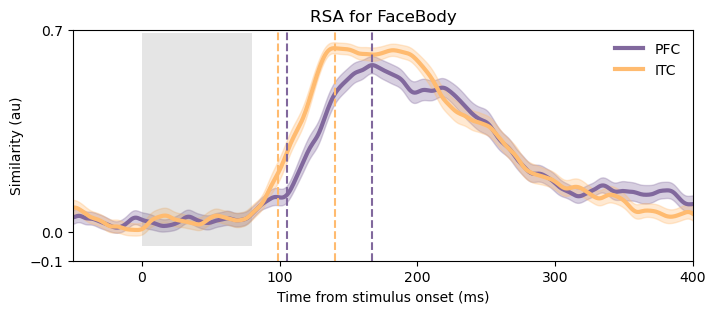

In [241]:
plot_xlim = [-50,400]
figure_size=(8,3)

m_plot(np.array([pfc,itc]), 3, [[129, 104, 157, 80],[255, 187, 112, 80]], ['PFC','ITC'],
       'RSA for '+myCond, timepoints=time_stamps, figure_size=figure_size)

plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylim([-.1,.7])
plt.yticks([-.1,0,.7])

plt.xlabel('Time from stimulus onset (ms)')
plt.ylabel('Similarity (au)')

plt.axvline(np.nanmedian(onsets_pfc), ls='--', color=[129/255, 104/255, 157/255, 1])
plt.axvline(np.nanmedian(onsets_itc), ls='--', color=[255/255, 187/255, 112/255, 1])

plt.axvline(np.nanmedian(peak_pfc), ls='--', color=[129/255, 104/255, 157/255, 1])
plt.axvline(np.nanmedian(peak_itc), ls='--', color=[255/255, 187/255, 112/255, 1])

# plt.savefig(FigDir+'rsa_fb_both.svg')

Text(0.5, 1.0, 'Solution Time for FaceBody')

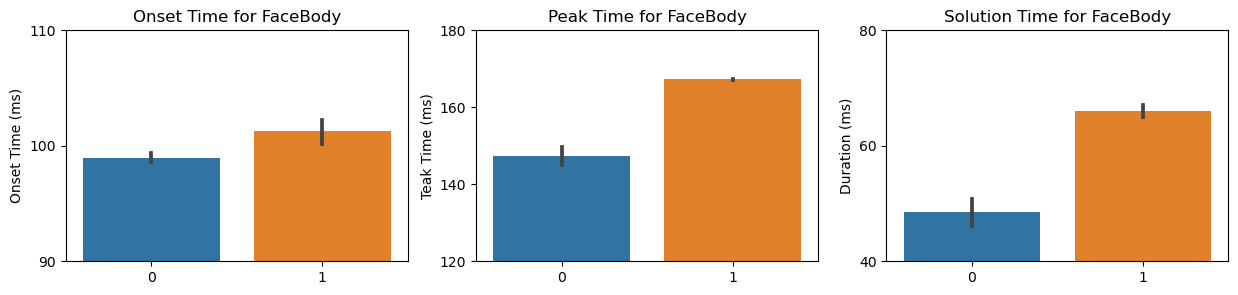

In [222]:
figure_size=(15,3)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)

onset_all = np.array([onsets_itc, onsets_pfc]).T
sns.barplot(ax=ax[0], data=onset_all)
ax[0].set_ylim([90,110])
ax[0].set_yticks([90,100,110])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title('Onset Time for '+myCond)

peak_all = np.array([peak_itc, peak_pfc]).T
sns.barplot(ax=ax[1], data=peak_all)
ax[1].set_ylim([120,180])
ax[1].set_yticks([120,140,160,180])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title('Peak Time for '+myCond)

sol_time = peak_all - onset_all
sns.barplot(ax=ax[2], data=sol_time)
ax[2].set_ylim([40,80])
ax[2].set_yticks([40,60,80])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title('Solution Time for '+myCond)

# plt.savefig(FigDir+'rsa_fb_stat_both.svg')

WilcoxonResult(statistic=1353.5, pvalue=0.0)

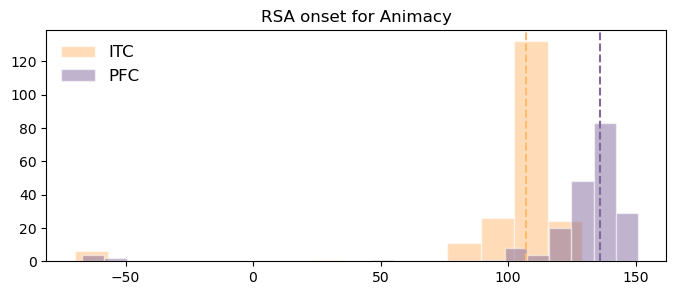

In [183]:
figure_size = (8,3)
times = time_stamps
base_time_idx = (times>-50) & (times<50)
std_thr = 10

onsets_itc = []
for i,iRep in enumerate(smooth(itc,3)):
    tmp_base_std = np.nanstd(iRep[base_time_idx])
    
    bools = iRep > std_thr*tmp_base_std
    if bools.sum()>0: onsets_itc.append(times[bools][0])
    else: onsets_itc.append(np.nan)

onsets_pfc = []
for i,iRep in enumerate(smooth(pfc,3)):
    tmp_base_std = np.nanstd(iRep[base_time_idx])
    
    bools = iRep > std_thr*tmp_base_std
    if bools.sum()>0: onsets_pfc.append(times[bools][0])
    else: onsets_pfc.append(np.nan)


plt.figure(figsize=figure_size)
plt.hist(onsets_itc, bins=15, alpha=.5, label='ITC', facecolor=[255/255, 187/255, 112/255, 1], edgecolor=[1,1,1])
plt.hist(onsets_pfc, bins=25, alpha=.5, label='PFC', facecolor=[129/255, 104/255, 157/255, 1], edgecolor=[1,1,1])
plt.title('RSA onset for '+myCond)
plt.legend(frameon=False, fontsize=12)
# plt.xlim([70,140])
plt.axvline(np.nanmedian(onsets_itc), ls='--', color=[255/255, 187/255, 112/255, 1])
plt.axvline(np.nanmedian(onsets_pfc), ls='--', color=[129/255, 104/255, 157/255, 1])

idx_non_nan = np.array([(~np.isnan(onsets_pfc)) & (~np.isnan(onsets_itc))])[0]
wilcoxon(np.array(onsets_pfc)[idx_non_nan], np.array(onsets_itc)[idx_non_nan], method='exact')

In [184]:
times = time_stamps

peak_itc = []
for i,iRep in enumerate(smooth(itc,3)):
    peak_itc.append(times[np.argmax(iRep)])

peak_pfc = []
for i,iRep in enumerate(smooth(pfc,3)):
    peak_pfc.append(times[np.argmax(iRep)])

peak_itc = np.array(peak_itc)
peak_pfc = np.array(peak_pfc)

wilcoxon(peak_itc, peak_pfc, method='exact')

WilcoxonResult(statistic=0.0, pvalue=0.0)

Text(0.5, 1.0, 'Solution Time for Animacy')

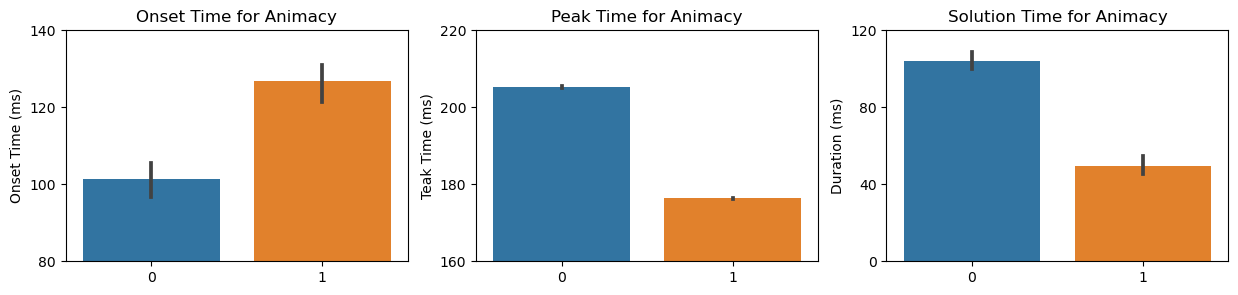

In [185]:
figure_size=(15,3)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)

onset_all = np.array([onsets_itc, onsets_pfc]).T
sns.barplot(ax=ax[0], data=onset_all)
ax[0].set_ylim([80,140])
ax[0].set_yticks([80,100,120,140])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title('Onset Time for '+myCond)

peak_all = np.array([peak_itc, peak_pfc]).T
sns.barplot(ax=ax[1], data=peak_all)
ax[1].set_ylim([160,220])
ax[1].set_yticks([160,180,200,220])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title('Peak Time for '+myCond)

sol_time = peak_all - onset_all
sns.barplot(ax=ax[2], data=sol_time)
ax[2].set_ylim([0,120])
ax[2].set_yticks([0,40,80,120])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title('Solution Time for '+myCond)

# plt.savefig(FigDir+'rsa_animacy_stat_both.svg')

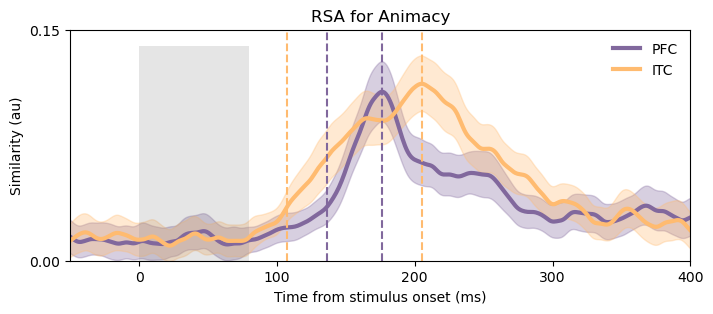

In [186]:
plot_xlim = [-50,400]
figure_size=(8,3)

m_plot(np.array([pfc,itc]), 3, [[129, 104, 157, 80],[255, 187, 112, 80]], ['PFC','ITC'],
       'RSA for '+myCond, timepoints=time_stamps, figure_size=figure_size)

plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylim([0,.15])
plt.yticks([0,.15])

plt.xlabel('Time from stimulus onset (ms)')
plt.ylabel('Similarity (au)')

plt.axvline(np.nanmedian(onsets_pfc), ls='--', color=[129/255, 104/255, 157/255, 1])
plt.axvline(np.nanmedian(onsets_itc), ls='--', color=[255/255, 187/255, 112/255, 1])

plt.axvline(np.nanmedian(peak_pfc), ls='--', color=[129/255, 104/255, 157/255, 1])
plt.axvline(np.nanmedian(peak_itc), ls='--', color=[255/255, 187/255, 112/255, 1])

# plt.savefig(FigDir+'rsa_animacy_both.svg')

  0%|          | 0/2 [00:00<?, ?it/s]

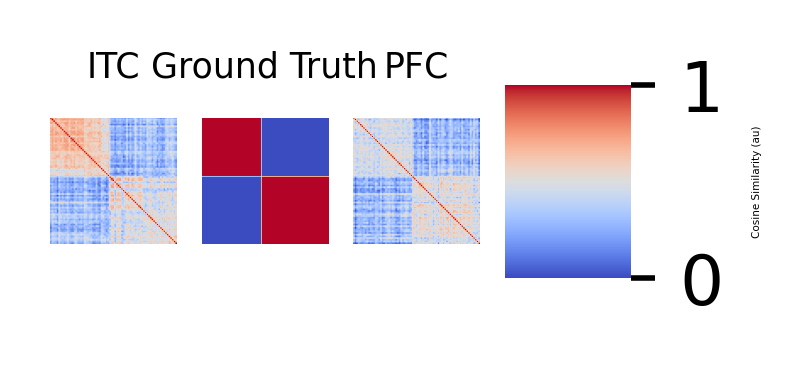

In [178]:
idx_peak_itc = np.argmin(abs((times - np.nanmedian(peak_itc))))
idx_peak_pfc = np.argmin(abs((times - np.nanmedian(peak_pfc))))

repmats = [mk_repmat_data(resp_it[:,ind_all,idx_peak_itc]),
           mk_repmat_kernel([len(indc1),len(indc2)]), 
           mk_repmat_data(resp_pfc[:,ind_all,idx_peak_pfc])]

plot_repmat(repmats,plot_sz=.5, titles=['ITC','Ground Truth','PFC'], show_clb=True)

# plt.savefig(FigDir+'repmat_fb_both.svg')


  0%|          | 0/2 [00:00<?, ?it/s]

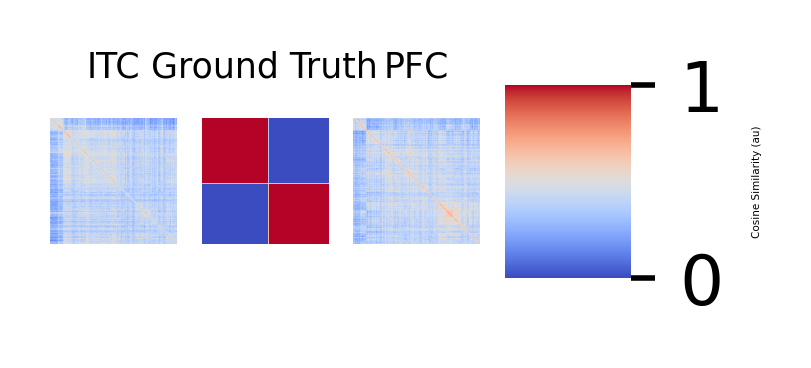

In [187]:
idx_peak_itc = np.argmin(abs((times - np.nanmedian(peak_itc))))
idx_peak_pfc = np.argmin(abs((times - np.nanmedian(peak_pfc))))

repmats = [mk_repmat_data(resp_it[:,ind_all,idx_peak_itc]),
           mk_repmat_kernel([len(indc1),len(indc2)]), 
           mk_repmat_data(resp_pfc[:,ind_all,idx_peak_pfc])]

plot_repmat(repmats,plot_sz=.5, titles=['ITC','Ground Truth','PFC'], show_clb=True)

# plt.savefig(FigDir+'repmat_animacy_both.svg')
